In [24]:
import pandas as pd
import numpy as np
import re
from string import punctuation
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
sns.set()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8015296168958163763
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4152360960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2180580089137340154
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [14]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv", encoding = 'latin', header=None)
df.columns = ['label', 'id', 'date', 'query', 'user', 'text']

In [15]:
df = df.drop(['id', 'date', 'query', 'user'], axis=1)
df = df.replace({'label': {0: 0, 4: 1}})

In [16]:
stop_words = set(stopwords.words('english'))

def remove_url(text):
    urlfree = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    return urlfree

def remove_mention(text):
    mentionfree=re.sub(r'\@\w+|\#','', text)
    return mentionfree

def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in punctuation])
    return punctuationfree

def remove_stopwords(text):
    stopwordsfree=" ".join([word for word in str(text).split() if word not in stop_words])
    return stopwordsfree 

In [17]:
df['text']= df['text'].apply(lambda x: remove_url(x))
df['text']= df['text'].apply(lambda x: remove_mention(x))
df['text']= df['text'].apply(lambda x: remove_punctuation(x))
df['text']= df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: remove_stopwords(x))

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((1280000, 2), (320000, 2))

In [19]:
def fit_tokenizer(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

tokenizer = fit_tokenizer(df_train.text, "<OOV>")

In [20]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, maxlen=maxlen, truncating=truncating, padding=padding)
    return pad_trunc_sequences

padding, truncating, max_len = 'post', 'post', 100
train_pad_trunc_seq = seq_pad_and_trunc(df_train.text, tokenizer, padding, truncating, max_len)
val_pad_trunc_seq = seq_pad_and_trunc(df_test.text, tokenizer, padding, truncating, max_len)
train_labels = np.array(df_train.label)
test_labels = np.array(df_test.label)
word_index = tokenizer.word_index

In [21]:
def model_evaluation(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':15}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':15}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':20}, pad = 20)

### GRU

In [10]:
def create_model(vocab_size, embedding_dim=300, maxlen=100, 
        filters=128, kernel_size=3, lstm1_dim=128, lstm2_dim=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, return_sequences=False)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True, name='SGD')
    model.compile(loss='binary_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    return model

model_GRU = create_model(len(word_index))
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          115465800 
                                                                 
 bidirectional (Bidirectiona  (None, 200)              241200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                        

In [11]:
history = model_GRU.fit(train_pad_trunc_seq, train_labels, epochs=10, validation_data=(val_pad_trunc_seq, test_labels))

Epoch 1/10
40000/40000 [==============================] - 893s 22ms/step - loss: 0.5642 - accuracy: 0.6970 - val_loss: 0.4807 - val_accuracy: 0.7686
Epoch 2/10
40000/40000 [==============================] - 888s 22ms/step - loss: 0.4725 - accuracy: 0.7754 - val_loss: 0.4668 - val_accuracy: 0.7776
Epoch 3/10
40000/40000 [==============================] - 892s 22ms/step - loss: 0.4578 - accuracy: 0.7845 - val_loss: 0.4575 - val_accuracy: 0.7827
Epoch 4/10
40000/40000 [==============================] - 895s 22ms/step - loss: 0.4487 - accuracy: 0.7901 - val_loss: 0.4541 - val_accuracy: 0.7841
Epoch 5/10
40000/40000 [==============================] - 895s 22ms/step - loss: 0.4419 - accuracy: 0.7939 - val_loss: 0.4519 - val_accuracy: 0.7852
Epoch 6/10
40000/40000 [==============================] - 893s 22ms/step - loss: 0.4361 - accuracy: 0.7974 - val_loss: 0.4494 - val_accuracy: 0.7883
Epoch 7/10
40000/40000 [==============================] - 897s 22ms/step - loss: 0.4310 - accuracy: 0.8004

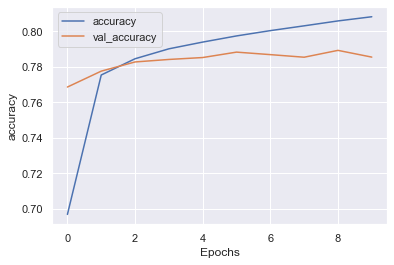

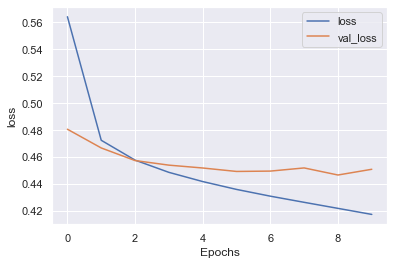

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
model_GRU.save('tmp/model_GRU')

INFO:tensorflow:Assets written to: tmp/model_GRU\assets


INFO:tensorflow:Assets written to: tmp/model_GRU\assets


In [22]:
model_GRU = tf.keras.models.load_model('tmp/model_GRU')

10000/10000 [==============================] - 111s 11ms/step
              precision    recall  f1-score   support

           0       0.76      0.84      0.80    159494
           1       0.82      0.73      0.77    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.78    320000
weighted avg       0.79      0.79      0.78    320000



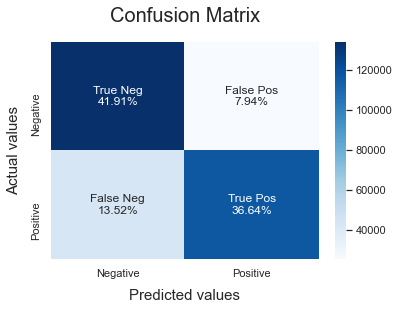

In [23]:
model_evaluation(model_GRU, val_pad_trunc_seq, test_labels)

### LSTM

In [9]:
def create_model(vocab_size, embedding_dim=300, maxlen=100):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2, nesterov=True, name='SGD')
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy']) 
    return model

model_LSTM = create_model(len(word_index))
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          115465800 
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           115328    
                                                                 
 bidirectional (Bidirectiona  (None, 98, 256)          263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [10]:
history = model_LSTM.fit(train_pad_trunc_seq, train_labels, epochs=10, validation_data=(val_pad_trunc_seq, test_labels))

Epoch 1/10
40000/40000 [==============================] - 1735s 43ms/step - loss: 0.6007 - accuracy: 0.6443 - val_loss: 0.4861 - val_accuracy: 0.7645
Epoch 2/10
40000/40000 [==============================] - 1782s 45ms/step - loss: 0.4754 - accuracy: 0.7755 - val_loss: 0.4617 - val_accuracy: 0.7824
Epoch 3/10
40000/40000 [==============================] - 1796s 45ms/step - loss: 0.4570 - accuracy: 0.7860 - val_loss: 0.4530 - val_accuracy: 0.7863
Epoch 4/10
40000/40000 [==============================] - 1801s 45ms/step - loss: 0.4453 - accuracy: 0.7926 - val_loss: 0.4531 - val_accuracy: 0.7869
Epoch 5/10
40000/40000 [==============================] - 1787s 45ms/step - loss: 0.4362 - accuracy: 0.7979 - val_loss: 0.4457 - val_accuracy: 0.7903
Epoch 6/10
40000/40000 [==============================] - 1794s 45ms/step - loss: 0.4280 - accuracy: 0.8026 - val_loss: 0.4419 - val_accuracy: 0.7931
Epoch 7/10
40000/40000 [==============================] - 1785s 45ms/step - loss: 0.4201 - accuracy:

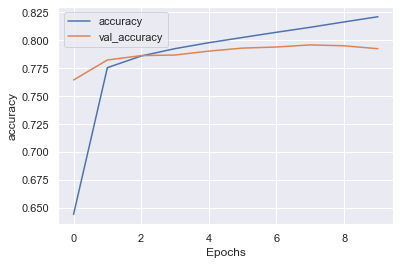

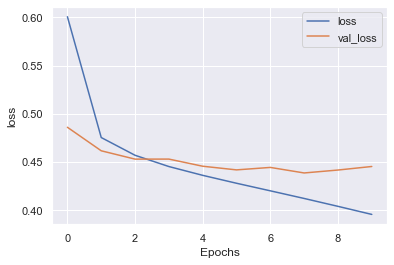

In [11]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
model_LSTM.save('tmp/model_LSTM')

INFO:tensorflow:Assets written to: tmp/model_LSTM\assets


INFO:tensorflow:Assets written to: tmp/model_LSTM\assets


In [25]:
model_LSTM = tf.keras.models.load_model('tmp/model_LSTM')

10000/10000 [==============================] - 204s 20ms/step
              precision    recall  f1-score   support

           0       0.83      0.74      0.78    159494
           1       0.76      0.85      0.80    160506

    accuracy                           0.79    320000
   macro avg       0.80      0.79      0.79    320000
weighted avg       0.80      0.79      0.79    320000



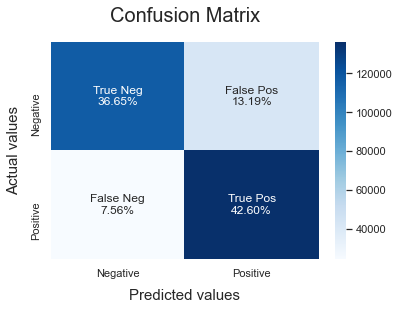

In [26]:
model_evaluation(model_LSTM, val_pad_trunc_seq, test_labels)